訓練データを入手して可視化する
=========================


## データの入手

以下のコードを実行し，訓練データを読み込みます

In [2]:
import numpy as np
import pandas as pd
import pathlib

train_data_path = pathlib.Path("../input/spaceship-titanic/train.csv")
train_data = pd.read_csv(
    train_data_path,
    dtype={
        "PassengerId": "string",
        "HomePlanet": "string",
        "Cabin": "string",
        "Destination": "string",
    },
)

```{note}
Kaggle 上でノートブックを実行するとパスは Unix 形式になっていて区切り文字が `/` ですが，Windowsだと異なります．この違いを吸収するために `pathlib` ライブラリを使用しています．
```

一般には訓練データからテストデータを取り分ける作業が必要ですが，このコンペティションではテストデータと訓練データはあらかじめ取り分けられていますので，ここで読んだデータが訓練データになります．

`head` メソッドで最初の５行を見てみます．

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


14個の列がありますが，この各列について与えられている説明は下記の通りです．


```{note}
- `PassengerId` - 各旅客のユニークな ID. 各 ID は `ggggg_pp` の形式をとり，`ggggg` は乗客が一緒に旅行しているグループ，`pp` はそのグループ内の番号です. グループ内の人は家族であることが多いですが，常に家族とは限りません
- `HomePlanet` - 旅客が出発した惑星で，通常は定住している惑星です.
- `CryoSleep` - 航海中，お客様が仮死状態になることを選択されたかどうかを示しています. 冷凍睡眠中のお客様は，キャビンに閉じ込められます.
- `Cabin` - 乗客が滞在するキャビン番号です. `deck/num/side` の形式で，side には P (Port)，S (Starboard) のいずれかが入ります.
- `Destination` - 乗客が降り立つ惑星です.
- `Age` - 搭乗者の年齢.
- `VIP` - 航海中に特別な VIP サービスを支払ったかどうか.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - 宇宙船タイタニック号の数々の豪華な設備で，お客様がそれぞれのサービスを利用した金額です.
- `Name` - 搭乗者の姓と名.
- `Transported` - 乗客が別の次元に転送されたかどうか. これがターゲットであり，予測しようとしている列です.
```

## 欠損値の調査

各列ごとに欠損値がどれだけあるかを調べます．

In [22]:
train_data.isnull().sum()

PassengerId         0
HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age               179
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
consuming_VSR     544
consuming_full    908
group               0
dtype: int64

`PassengerId` と `Transported` には欠損値がありませんが，それ以外の列には 100 ~ 200 行程度の欠損値があることがわかります．

In [4]:

total_row = train_data.shape[0]
total_row

8693

全体の行数は 8693 ですね．

## ヒストグラムを描画する

訓練データには数値型のものと，カテゴリになっているものと，Bool値が入っているものがありました．

そのうち数値型のものはヒストグラムを描画するとよりイメージしやすくなります．

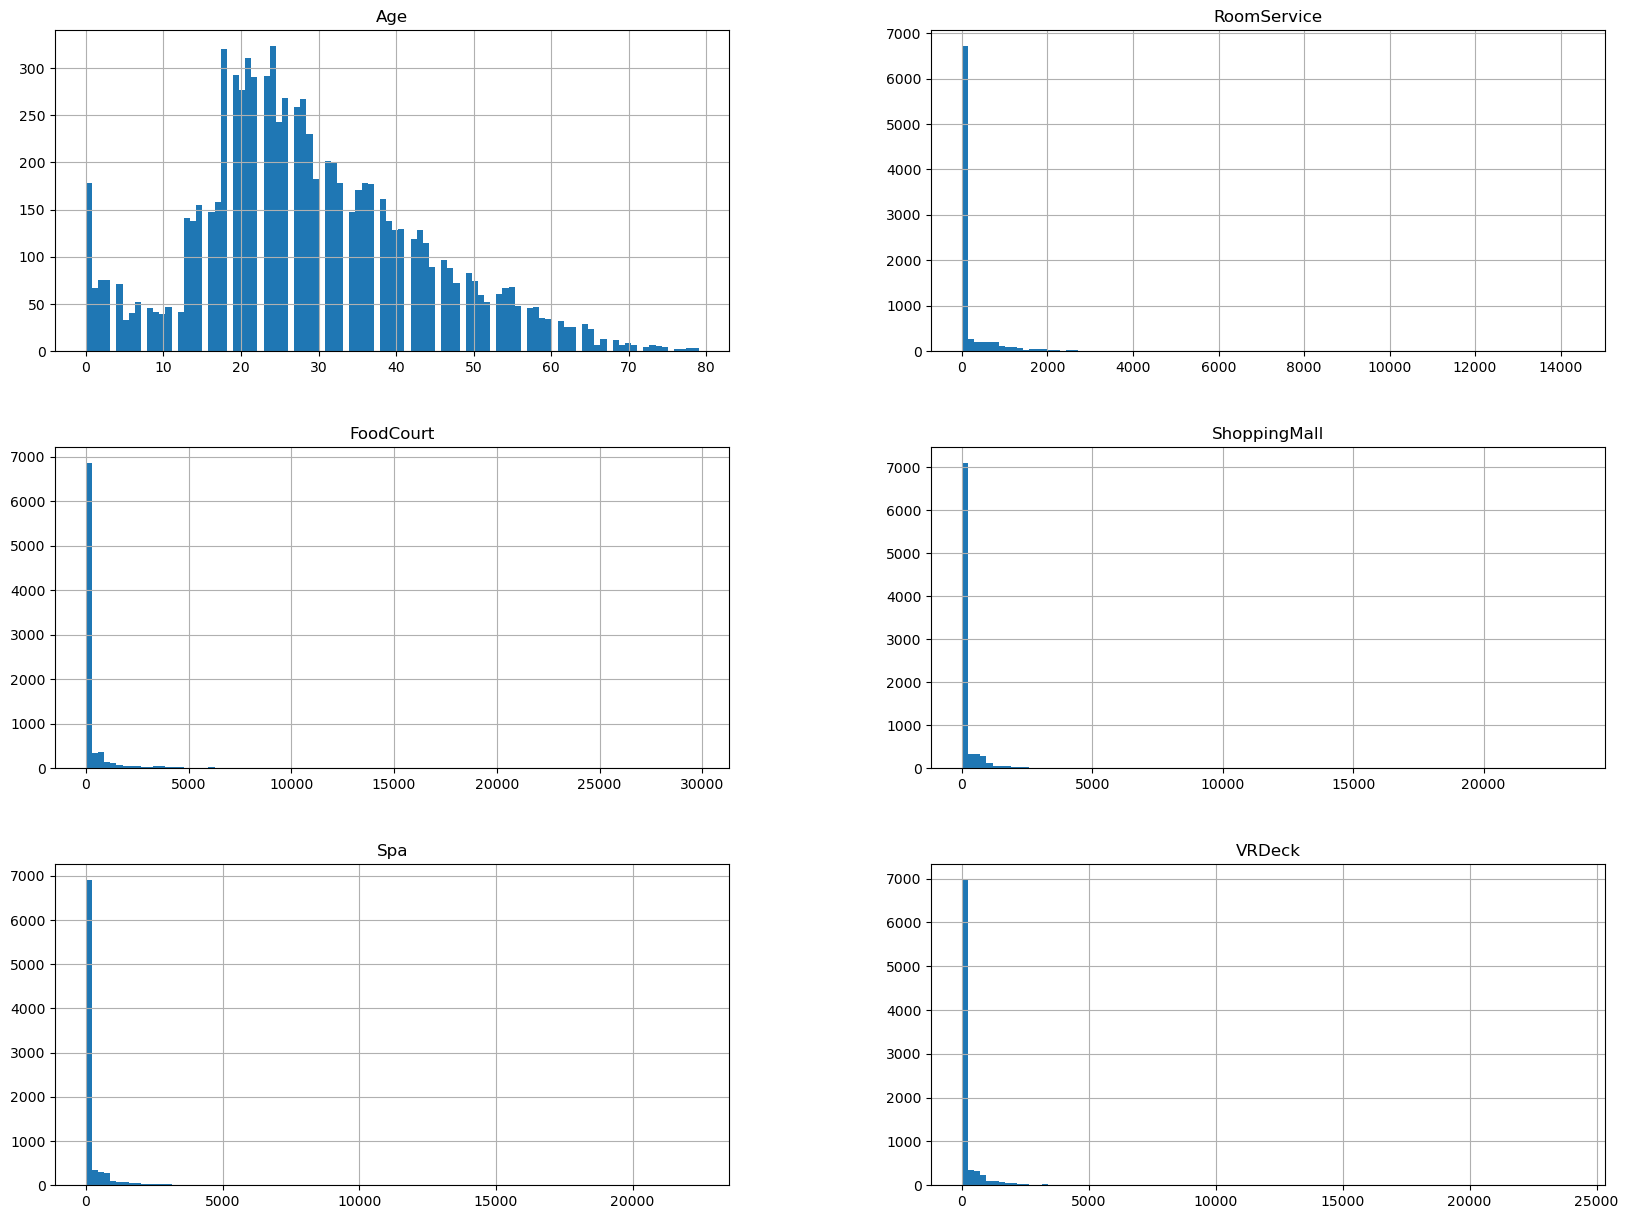

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(bins=100, figsize=(20, 15))
plt.show()


ヒストグラムを出力することができました．少し小さいので，個別にも出してみます．

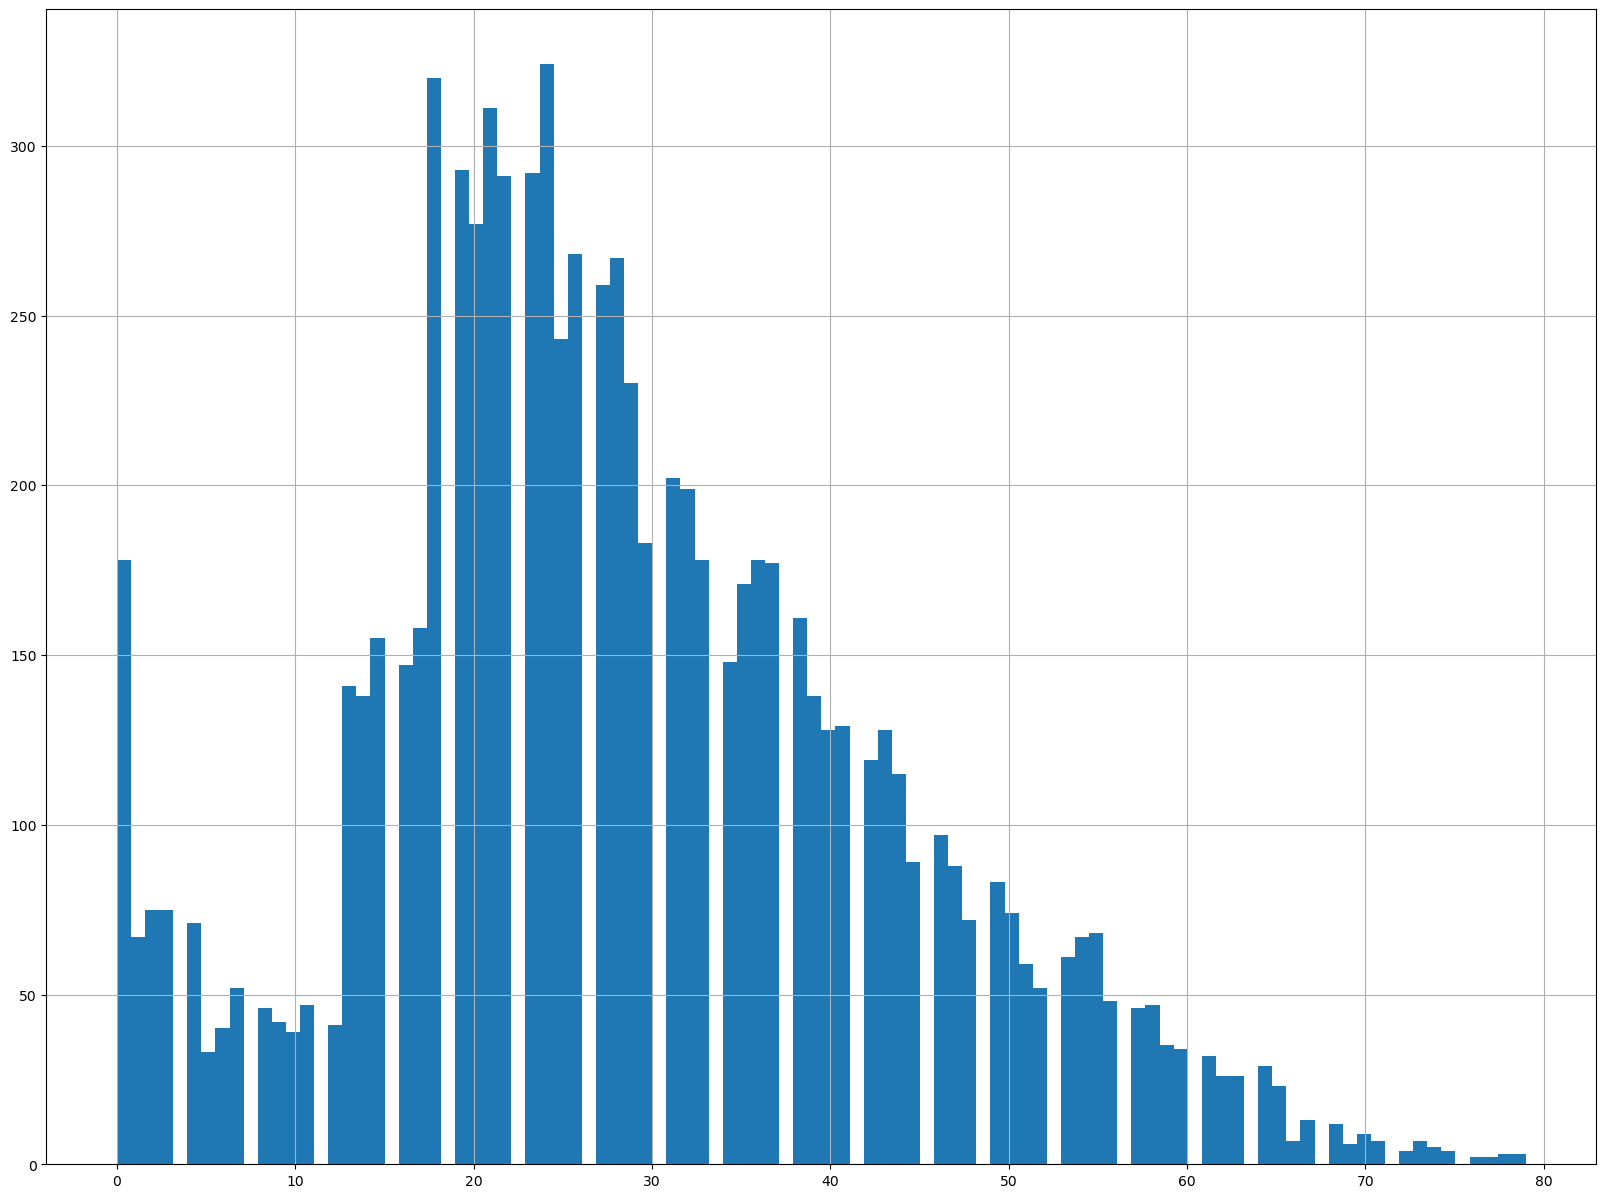

In [7]:
train_data["Age"].hist(bins=100, figsize=(20, 15))
plt.show()

`Age` のヒストグラムを見ていると，次のようなことがわかります．

* 理由は不明ですが，３歳～４歳の間隔でまったくデータがない列があります．一方で突出して大きいところもあります．
* 20歳のあたりと０歳のところが山のようになっています

他のヒストグラムも出してみましょう．

他はすべて似たような形なので，`RoomService` だけ出力します．

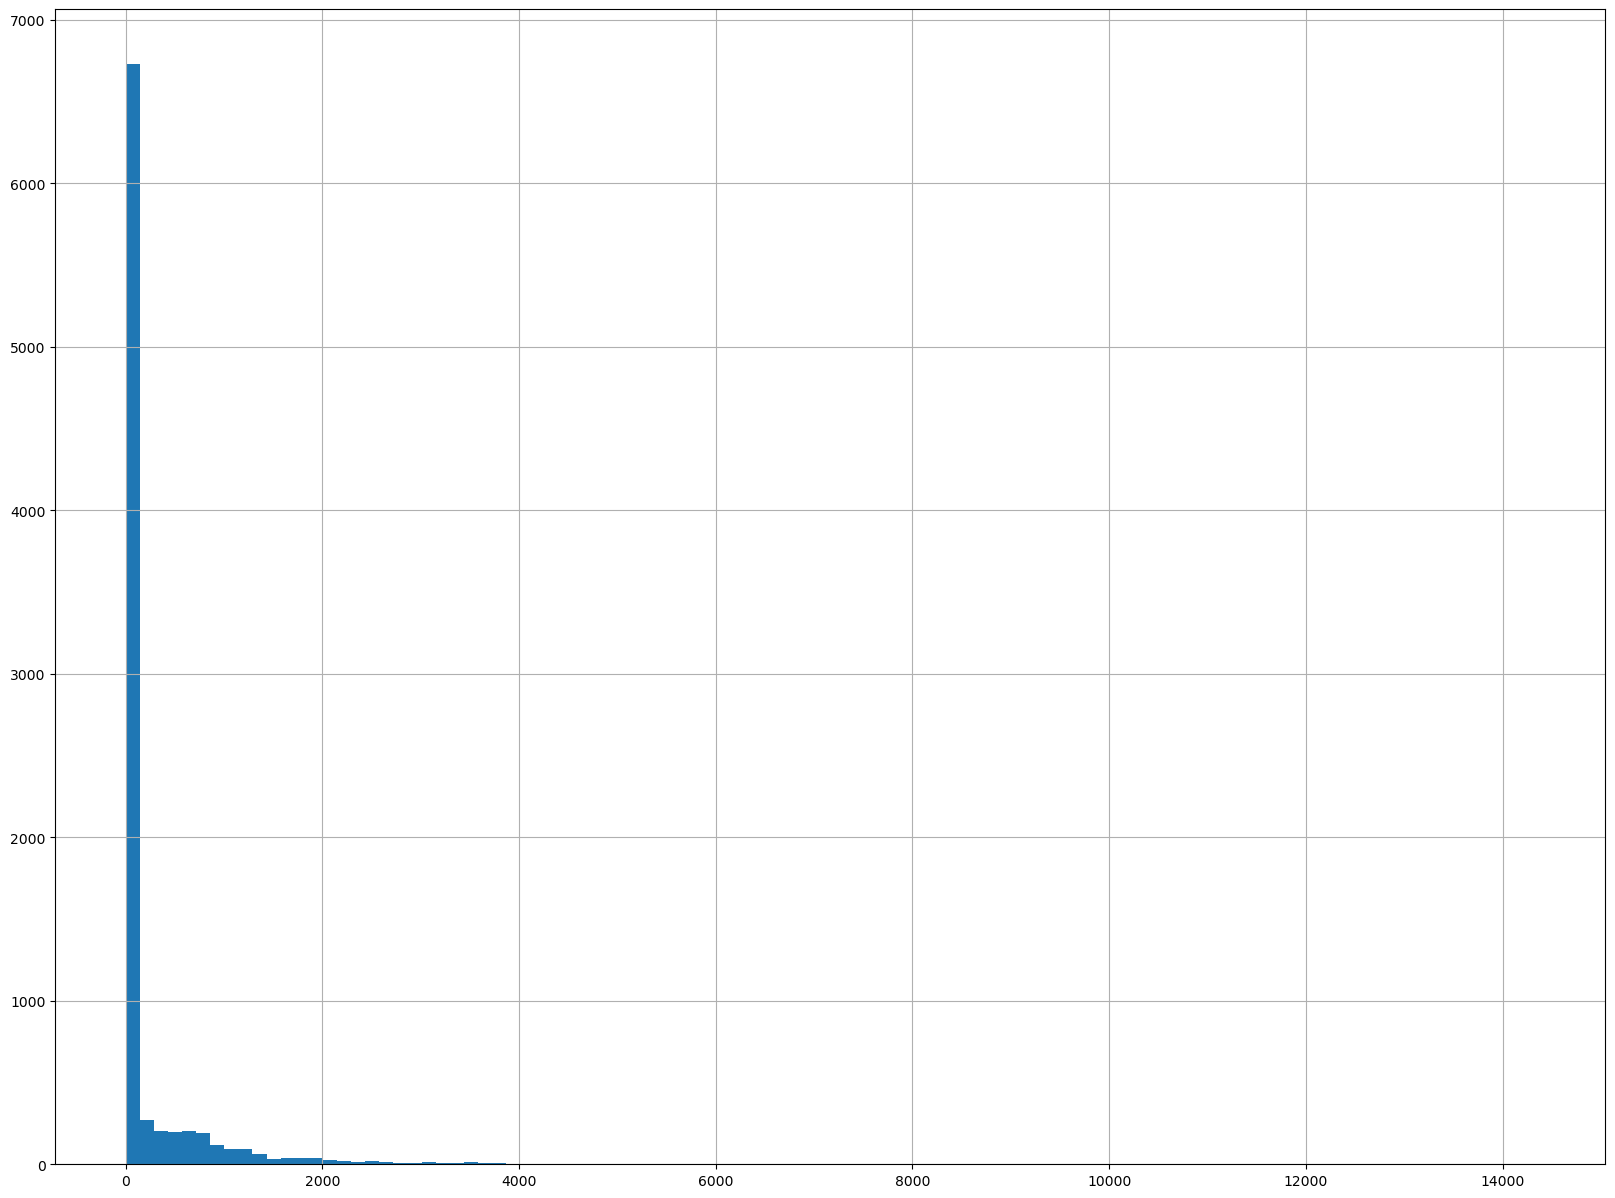

In [9]:
train_data["RoomService"].hist(bins=100, figsize=(20, 15))
plt.show()

データの高低差が大きすぎて見づらいので，対数スケールに変換してみます．

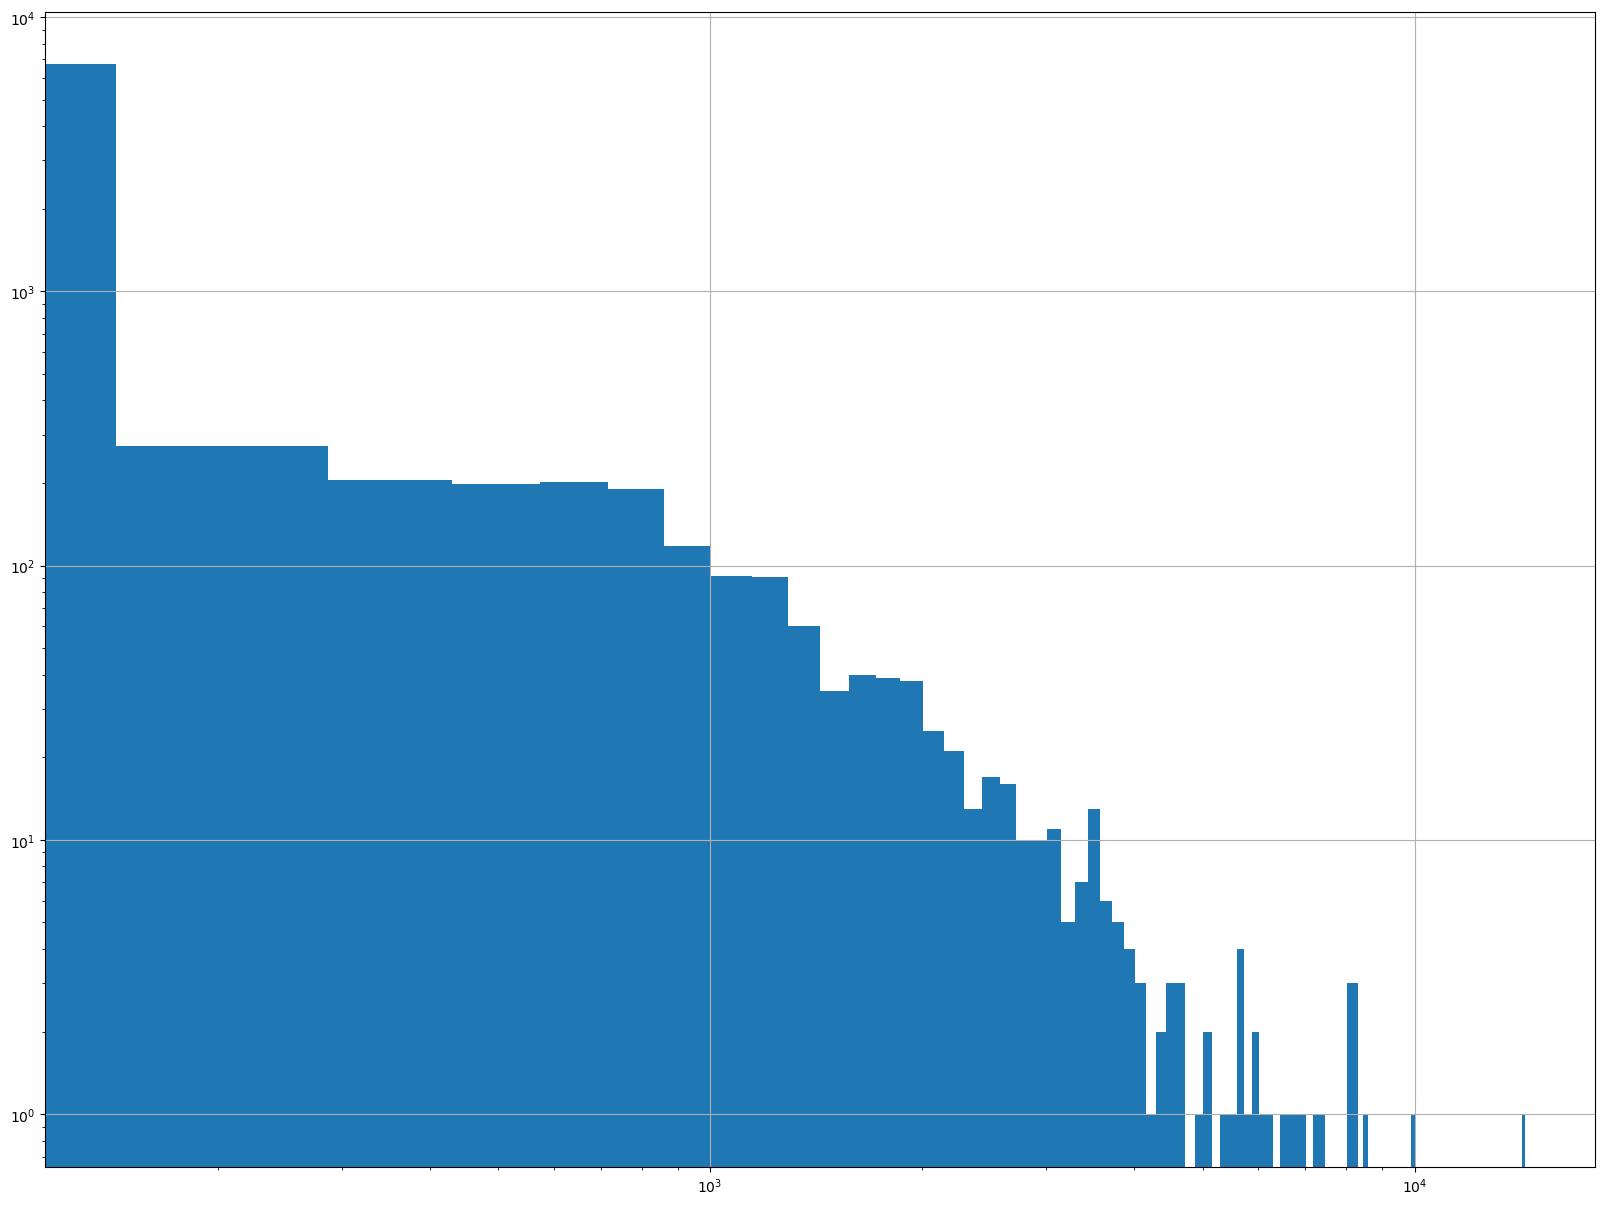

In [12]:
train_data["RoomService"].hist(bins=100, figsize=(20, 15))
plt.xscale('log')
plt.yscale('log')
plt.show()

見やすいグラフになりました．

この「対数スケールに変換する」という技法は覚えておいた方が良さそうです．

## 円グラフを描画する

ヒストグラムでデータを可視化するのは良いアイデアですが，数値に対してしか使うことができません．

`HomePlanet` などのカテゴリが格納されいている列や，Bool型の列については，他の方法で可視化する必要があります．

ここでは円グラフを使ってみます．

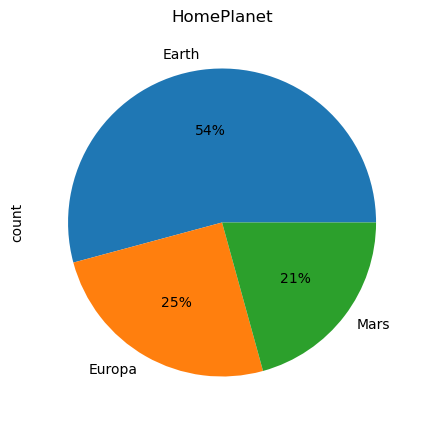

In [18]:
train_data["HomePlanet"].value_counts().plot.pie(
    y="count", figsize=(5, 5), autopct="%1.0f%%", title="HomePlanet"
)
plt.show()

全部で `Earth`, `Mars`, `Europa` の３つのカテゴリがあり，それぞれ図に示したような割合で出現することがわかりました．

数をそのまま出すこともできて，それには次のように `value_counts()` メソッドを使用します．

In [19]:
train_data["HomePlanet"].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: Int64

変数がとる値の可能性が少ないときは円グラフとして出した方が見やすいですね．

変数がとる値が多すぎると，円グラフでは表現しきれませんが……．

ほかの特徴量についてもやってみます．

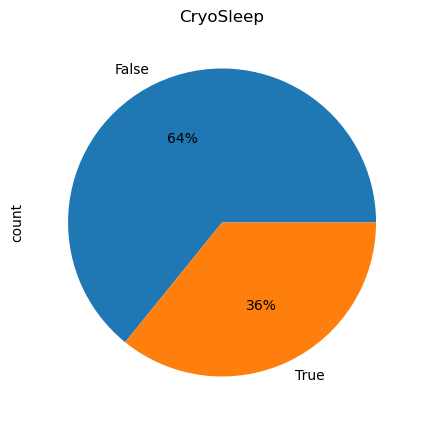

In [6]:
train_data["CryoSleep"].value_counts().plot.pie(
    y="count", figsize=(5, 5), autopct="%1.0f%%", title="CryoSleep"
)
plt.show()

`Cabin` は値が多様なので，円グラフにはできません．ここでは単に値だけ出しておきます．

In [25]:
train_data["Cabin"].value_counts()

Cabin
G/734/S     8
B/82/S      7
G/109/P     7
B/11/S      7
F/1411/P    7
           ..
G/1339/S    1
F/1633/P    1
G/1350/P    1
B/309/S     1
F/947/P     1
Name: count, Length: 6560, dtype: Int64

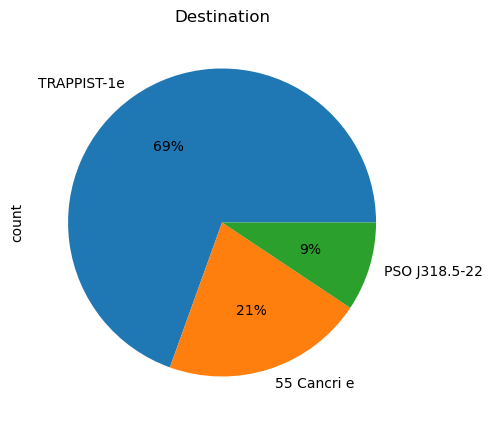

In [7]:
train_data["Destination"].value_counts().plot.pie(
    y="count", figsize=(5, 5), autopct="%1.0f%%", title="Destination"
)
plt.show()

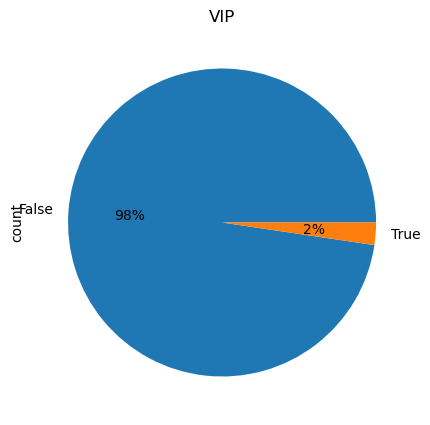

In [8]:
train_data["VIP"].value_counts().plot.pie(
    y="count", figsize=(5, 5), autopct="%1.0f%%", title="VIP"
)
plt.show()

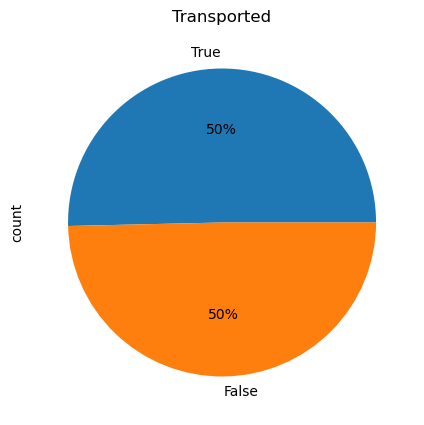

In [9]:
train_data["Transported"].value_counts().plot.pie(
    y="count", figsize=(5, 5), autopct="%1.0f%%", title="Transported"
)
plt.show()